In [1]:
from savejupyterdata import load, save
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()

import os
import time
import re
import numba

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Data preclean

In [2]:
fd_pos = pd.read_csv('pos_definitions.csv')
fd_neg = pd.read_csv('neg_definitions.csv')
into_pos = pd.read_csv('pos_featureValues.csv')
into_neg = pd.read_csv('neg_featureValues.csv')


fd_pos.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
fd_neg.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
into_pos.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
into_neg.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)

def remove_first_two_num(col):
    if re.match('^[0-9]{2}.*.mzXML', col):
        return col[2:-6].replace('_pos', '').replace('_neg', '')
    elif 'QC' in col:
        return col[:-6].replace('_pos', '').replace('_neg', '')
    else:
        return col.replace('_pos', '').replace('_neg', '')
    
into_pos.rename(columns=remove_first_two_num, inplace=True)
into_neg.rename(columns=remove_first_two_num, inplace=True)

In [7]:
def get_index(cols):
    qcs = []
    filters = []
    tests = []
    for i, col in enumerate(cols):
        if col.startswith('QC'):
            qcs.append(i)
        elif col.startswith('Fi'):
            filters.append(i)
        else:
            tests.append(i)
    return qcs, filters, tests

In [8]:
def classify(col):
    if 'cond' in col:
        return col[:-1]
    else:
        return re.match('(.*)_.*', col)[1]

In [295]:
def draw_pca(df, fi=False):
    
    qcs, filters, tests = get_index(df.columns)
    if not fi:
        df = df[df.columns^df.columns[filters]]
    hues = []
    for col in df.columns:
        hues.append(classify(col))
        
    cols = df.columns
    data = StandardScaler().fit_transform(df.values.T)
    pca = PCA(n_components=8, whiten=True).fit_transform(data)
    #pca = PCA(n_components=8).fit_transform(df.values.T)
    pca_df = pd.DataFrame(pca)
    pca_df['cate'] = hues
    pca_df.index=cols
    colormap = {'QC':'grey', 'QC_cond':'lightgrey',
                'A': 'coral', 'B': 'orange', 'C': 'forestgreen',
                'D': 'yellow', 'E': 'crimson', 'F': 'royalblue'}
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    sns.scatterplot(0, 1, hue='cate', data=pca_df, s=300, palette=colormap, alpha=.8, ax=ax)
    
    pca_df = pca_df.reindex(df.columns[1:]).dropna()

    for i, ind in enumerate(pca_df.index):
        ax.text(pca_df.loc[ind, 0], pca_df.loc[ind, 1]+.1, i+1, color='maroon', fontsize=14)
        
    ax.legend(fontsize=18, bbox_to_anchor=[1,1,0,0])
    plt.tight_layout()
    return pca_df

In [95]:
class MoreThanOneIndexCol(Exception):
    pass

# Filter and EDA

In [71]:
index_neg_qc, index_neg_filter, index_neg_tests = get_index(into_neg.columns)
index_pos_qc, index_pos_filter, index_pos_tests = get_index(into_pos.columns)

In [11]:
filters_pos = into_pos.iloc[:, index_pos_filter]
filters_pos = filters_pos.T.sort_index().T

In [3]:
from collections import defaultdict

In [85]:
class ChromatographData():
    """
    Objects contain data and transform method
    """
    def __init__(self, data, polarity='postive', feature_index_col='parse'):
        """
        :data: pd.DataFrame
        :polarity: 'positive' or 'negative'
        :feature_index_col: col identifier if there is
        """
        #self._polartity
        if not any([polarity.lower() in two for two in ['positive', 'negative']]):
            raise ValueError(f'invalid polarity parameter!{polarity}')
        if polarity.lower() in 'positive':
            self._polarity = 'Positive'
        else:
            self._polarity = 'Negative'
        
        #self._data and self._index
        if feature_index_col =='parse':
            self._index = data.loc[:, data.dtypes==np.object]
            if self._index.shape[1]>1:
                raise MoreThanOneIndexCol(
                    f'data has {self._index.shape[1]} object columns! (must be 1)')
            self._data = data.loc[:, data.dtypes!=np.object]
            
        elif isinstance(feature_index_col, int):
            self._index = pd.DataFrame(data.iloc[:, feature_index_col]).rename(
                columns={0:data.columns[feature_index_col]})
            self._data = data.loc[:, data.columns != data.columns[feature_index_col]]
        
        elif isinstance(feature_index_col, str):
            self._index = pd.DataFrame(data.loc[:, feature_index_col]).rename(
                columns={0:feature_index_col})
            self._data = data.loc[:, data.columns != feature_index_col]
            
        else:
            raise TypeError('feature_index_col must be "parse", int or str!')
        
        #get indices list about QCs, filters and test samples
        self._qc_indices, self._filter_indices, self._test_indices = self._get_index()
        self._categories = self._classify()
        
    def __repr__(self):
        """
        print Data status
        include data shape, process history
        """
        return(f'''Chromatograph data:\n
        data shape {self._data.shape}''')
    
    def _get_index(self):
        qcs = []
        filters = []
        tests = []
        for i, col in enumerate(self._data.columns):
            if col.startswith('QC'):
                qcs.append(i)
            elif col.startswith('Fi'):
                filters.append(i)
            else:
                tests.append(i)
        return [pd.Index(indices) for indices in [qcs, filters, tests]]
    
    @property
    def df(self):
        return self._data
    
    def _classify(self):
        cates = defaultdict(list)
        for i, col in enumerate(self._data.columns):
            if 'cond' in col:
                cates[col[:-1]].append(i)
            else:
                cates[re.match('(.*)_.*', col)[1]].append(i)
        return cates
    
    def deal_nan(self, method=None, value=None):
        if method is None and value:
            self._data.fillna(value)
        else:
            pass
        
    def fill_by_categories(self, method='median'):
        for cate, raw in self._categories.items():
            self._data.iloc[:, raw] = self._data.iloc[:, raw].apply(lambda x: x.fillna(x.median()), axis=1)
        self.fill_across_all_samples()
          
    def fill_fast(self):
        data = self._data.values
        return self.fill_helper(data)
    
    @numba.njit
    def fill_helper(self, temp, dic):
        
        for cate, raw in dic.items():
            raw_median = np.apply_along_axis(lambda x: np.nanmedian(x), 1, temp[:, raw])
            for i, row in enumerate(temp[:, raw]):
                temp_row = temp[row, raw]
                temp_row[np.isnan(temp_row)] = raw_median[i]
                temp[row, raw] = temp_row
        return temp

    def fill_across_all_samples(self):
        self._data = self._data.apply(lambda x: x.fillna(x.min())/(3**0.5), axis=1)

In [86]:
a = ChromatographData(into_pos, 'positive')

In [87]:
t = a.df.values.copy()

In [ ]:
cate = 

In [88]:
t

array([[              nan,    57054.94825797,   155214.23261319, ...,
        12289804.7285835 ,  7425814.76587617, 10647825.6958933 ],
       [              nan,  1110330.74892307,  2749260.90490337, ...,
         9790957.89801685,  5032225.31705493,  8941159.69386915],
       [ 6111992.04356953,  6217061.78285157,  6360392.02742777, ...,
         7962941.15904999,  1289303.34754043,  5857257.54599298],
       ...,
       [ 6144381.50647728,  2684806.9691293 ,  1770170.13927605, ...,
          997690.58190001,               nan,   860053.26915865],
       [              nan,   616760.48657811,  1045084.63598438, ...,
         4100704.04541016,    83541.20262988,  2180201.26729404],
       [              nan,   274770.60184491,   393539.41113281, ...,
         2316472.79101562,               nan,   947119.53466797]])

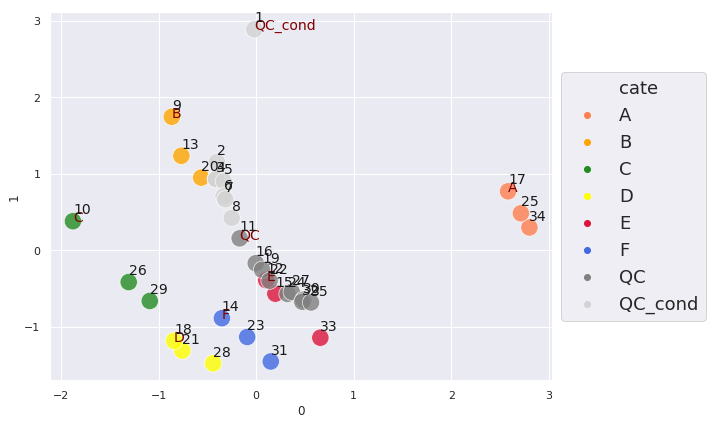

In [387]:
p = draw_pca(a.df)

In [388]:
save()

data saved


In [294]:
into_neg.loc[into_neg.isnull().any(1)];

In [295]:
a._categories

defaultdict(list,
            {'QC_cond': ['QC_cond1',
              'QC_cond2',
              'QC_cond3',
              'QC_cond4',
              'QC_cond5',
              'QC_cond6',
              'QC_cond7',
              'QC_cond8'],
             'B': ['B_1', 'B_2', 'B_3'],
             'Filter_030': ['Filter_030_1', 'Filter_030_3', 'Filter_030_2'],
             'Filter_015': ['Filter_015_1', 'Filter_015_3', 'Filter_015_2'],
             'C': ['C_2', 'C_1', 'C_3'],
             'QC': ['QC_1',
              'QC_2',
              'QC_3',
              'QC_4',
              'QC_5',
              'QC_6',
              'QC_7',
              'QC_8',
              'QC_9'],
             'E': ['E_2', 'E_1', 'E_3'],
             'F': ['F_1', 'F_2', 'F_3'],
             'Filter_010': ['Filter_010_2', 'Filter_010_1', 'Filter_010_3'],
             'A': ['A_2', 'A_3', 'A_1'],
             'Filter_050': ['Filter_050_3', 'Filter_050_1', 'Filter_050_2'],
             'D': ['D_3', 'D_1', 'D_2'],
   

In [426]:
s = pd.DataFrame([[5,np.NaN,7,9,10, np.NAN],
                 [10,np.NaN,np.NaN, 30, np.NAN],
                 [15,30,14,1, 10, np.NAN]]).T
s

,0,1,2
0,5.0,10.0,15.0
1,NaN,NaN,30.0
2,7.0,NaN,14.0
3,9.0,30.0,1.0
4,10.0,NaN,10.0
5,NaN,NaN,NaN


In [427]:
s = s.values

In [432]:
ss = s[1:5, 1]

In [433]:
ss

array([nan, nan, 30., nan])

In [436]:
s[1:5, 1]

array([nan, nan, 30., nan])

In [437]:
ss[np.isnan(ss)] = 5
s[1:5, 1] = ss
s

array([[ 5., 10., 15.],
       [nan,  5., 30.],
       [ 7.,  5., 14.],
       [ 9., 30.,  1.],
       [10.,  5., 10.],
       [nan, nan, nan]])

In [423]:
ss = 2
ss

2

In [402]:
s.apply(lambda x: x.fillna(x.mean()), axis=1)

,0,1,2
0,5.0,10.0,15.0
1,30.0,30.0,30.0
2,7.0,10.5,14.0
3,9.0,30.0,1.0
4,10.0,10.0,10.0
5,NaN,NaN,NaN


In [12]:
y_true = np.array([[i for j in range(3)] for i in [0.1, 0.15, 0.3, 0.5, .75, 1]]).ravel()

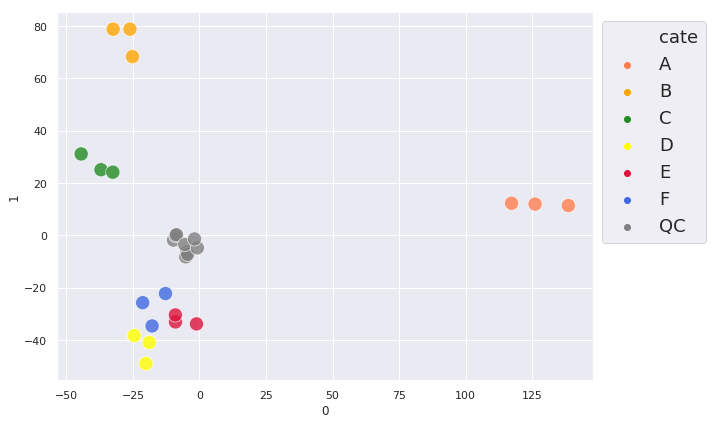

In [214]:
t = into_neg.iloc[:, 1:].dropna()

pca_df = draw_pca(t / (t.mean(0)/t.mean(0).max()))

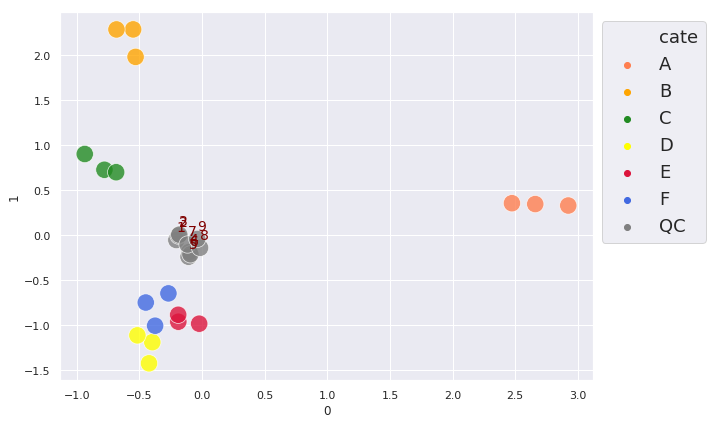

In [279]:
t = into_neg.iloc[:, 1:].dropna()

pca_df = draw_pca(t / (t.mean(0)/t.mean(0).max()))

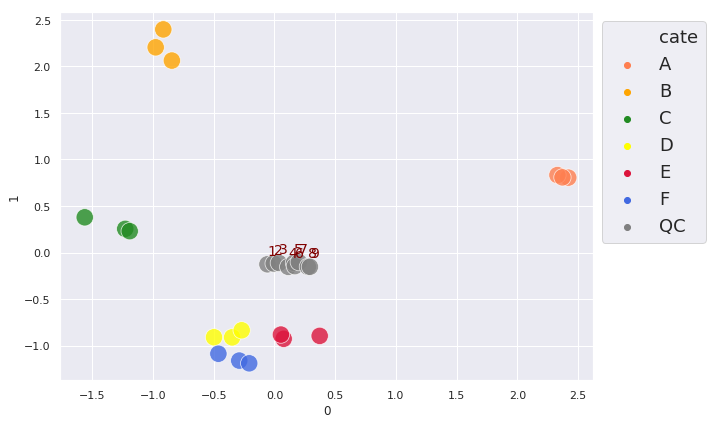

In [280]:
pca_df = draw_pca(into_neg.iloc[:, 1:].fillna(10))

In [9]:
d = {'a':123, 'b': 432}

In [11]:
d.get('c')

In [25]:
def draw_pca(df, fi=False, plot_cate=True):
    df_original_cols = df.columns
    qcs, filters, tests = get_index(df.columns)
    if not fi:
        df = df[df.columns^df.columns[filters]]
    hues = []
    for col in df.columns:
        hues.append(classify(col))
        
    cols = df.columns
    data = StandardScaler().fit_transform(df.values.T)
    pca = PCA(n_components=8, whiten=True).fit_transform(data)
    #pca = PCA(n_components=8).fit_transform(df.values.T)
    pca_df = pd.DataFrame(pca)
    pca_df['cate'] = hues
    pca_df.index=cols
    colormap = {'QC':'grey', 'QC_cond':'lightgrey',
                'A': 'coral', 'B': 'orange', 'C': 'forestgreen',
                'D': 'yellow', 'E': 'crimson', 'F': 'royalblue', 'Filter': 'navy', 
                'Filter_050':'#ffff66', 'Filter_015':'#ffffcc', 'Filter_075':'#ffff33', 
                'Filter_030':'#ffff99', 'Filter_010':'#ffffff', 'Filter_100':'#ffff00'}
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    sns.scatterplot(0, 1, hue='cate', data=pca_df, s=300, palette=colormap, alpha=.8, ax=ax)
    
    pca_df = pca_df.reindex(df_original_cols).dropna()
    
    dic_already_plotted = {}
    for i, ind in enumerate(pca_df.index):
        if plot_cate:
            cate_simple = pca_df.loc[ind, 'cate']
            if not dic_already_plotted.get(cate_simple):
                ax.text(pca_df.loc[ind, 0], pca_df.loc[ind, 1], cate_simple, color='maroon', fontsize=14)
                dic_already_plotted[cate_simple] = True
        ax.text(pca_df.loc[ind, 0], pca_df.loc[ind, 1]+.1, i+1, color='k', fontsize=14)
    ax.legend(loc='center left', fontsize=18, bbox_to_anchor=[1,.5])
    plt.tight_layout()
    return pca_df

In [36]:
((into_neg.iloc[:, 25][:, None]/into_neg.iloc[:, 1:]).median(0)).shape, into_neg.iloc[:, 1:].shape

((45,), (14753, 45))

In [51]:
t_neg = into_neg.iloc[:, 1:] * ((into_neg.iloc[:, 25][:, None]/into_neg.iloc[:, 1:]).median(0))

In [51]:
t_neg = into_neg.iloc[:, 1:] * ((into_neg.iloc[:, 25][:, None]/into_neg.iloc[:, 1:]).median(0))

In [52]:
t_pos = into_pos.iloc[:, 1:] * ((into_pos.iloc[:, 28][:, None]/into_pos.iloc[:, 1:]).median(0))

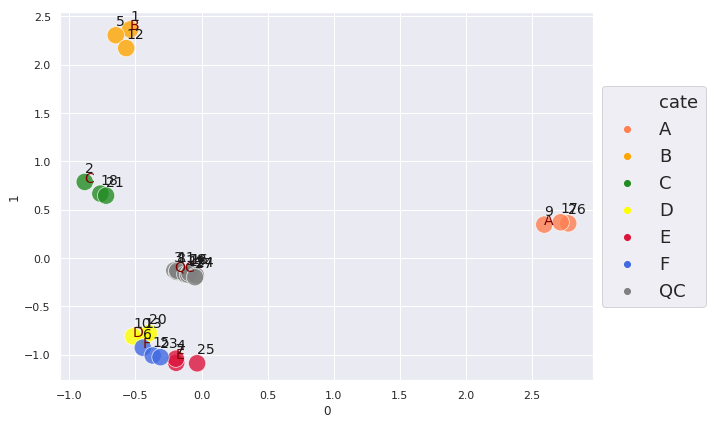

In [53]:
pca_df = draw_pca(t_neg.fillna(10))

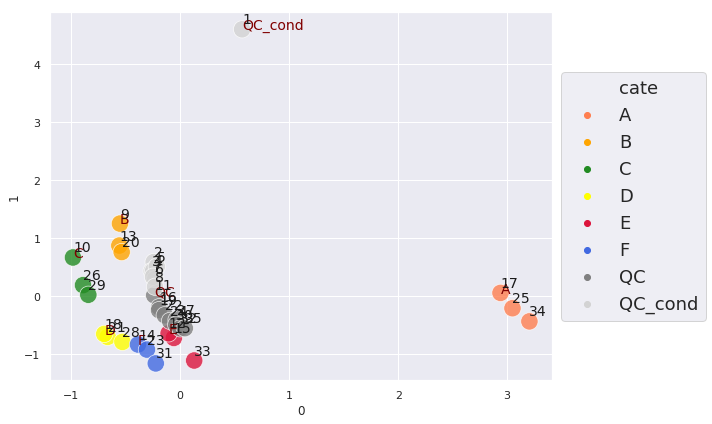

In [54]:
pca_df = draw_pca(t_pos.fillna(10))

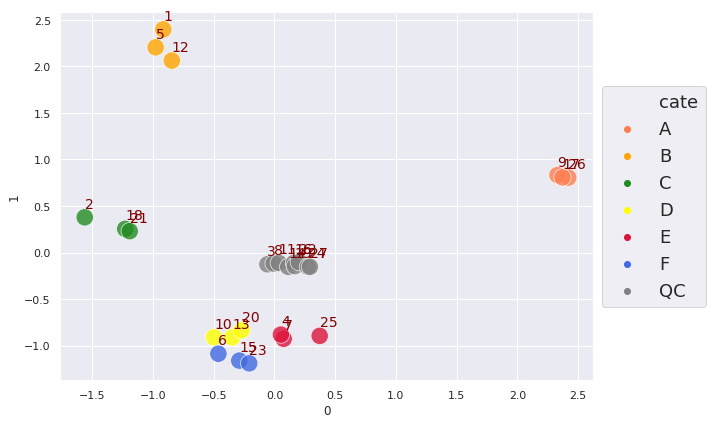

In [420]:
pca_df = draw_pca(into_neg.iloc[:, 1:].fillna(10))

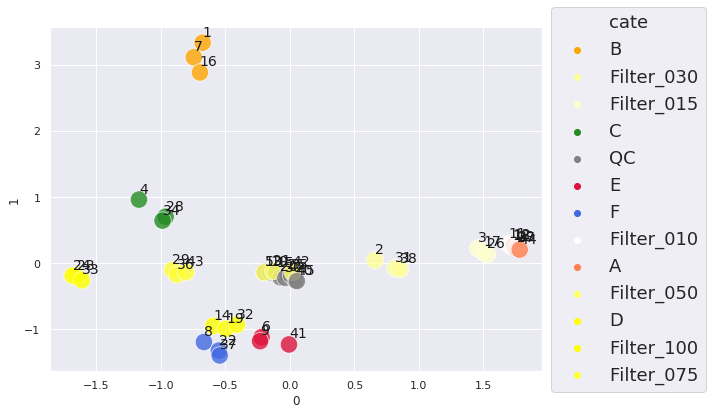

In [27]:
pca_df = draw_pca(into_neg.iloc[:, 1:].fillna(10), fi=True, plot_cate=False)

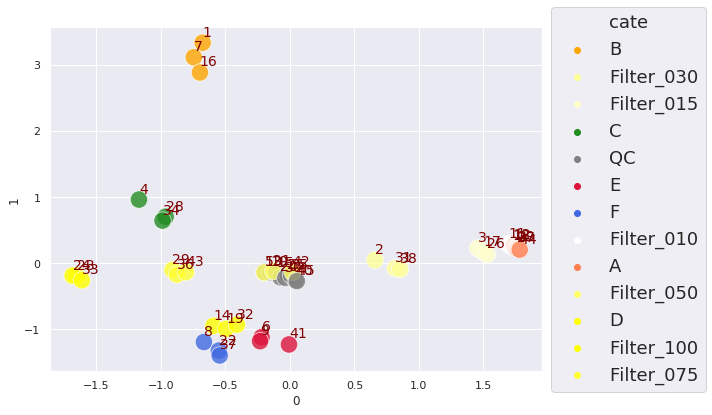

In [421]:
pca_df = draw_pca(into_neg.iloc[:, 1:].fillna(10), fi=True)

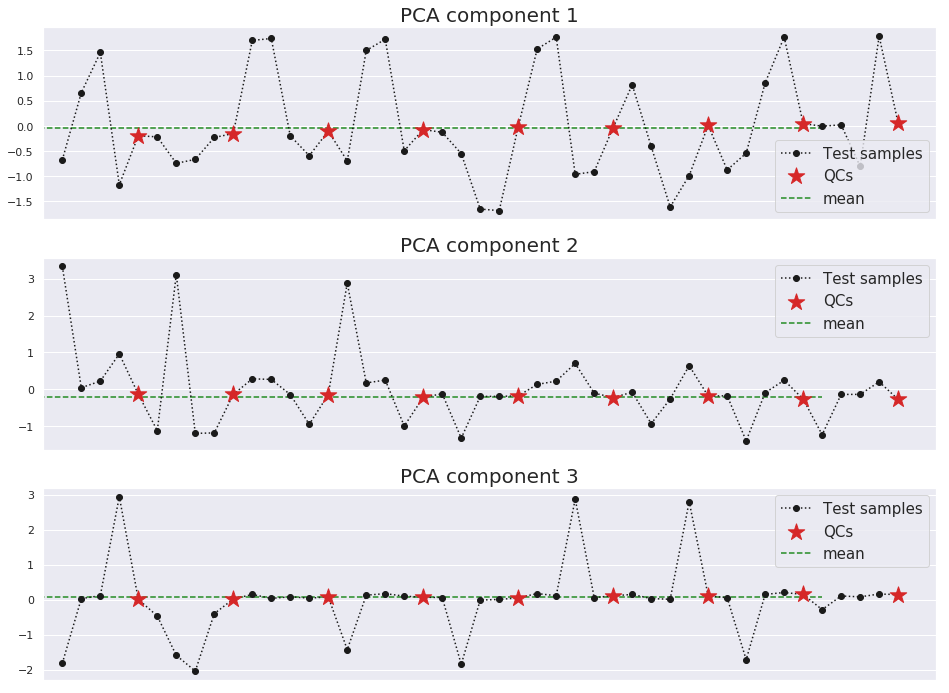

In [423]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(16,12))

_ = pca_df[pca_df.index.str.contains('QC')]
ax1.plot(pca_df[0], ':o', c='k', label='Test samples')
ax1.scatter(_.index, _[0], marker='*', s=300, c='tab:red', zorder=10, label='QCs')
ax1.set_xticklabels([])
ax1.set_title('PCA component 1', fontsize=20)
ax1.hlines(_[0].mean(), -10, 100, linestyle='--', color='forestgreen', label='mean')
ax1.set_xlim(-1,46)
ax1.legend(fontsize=15)
ax1.set_xticks([])

ax2.plot(pca_df[1], ':o', c='k', label='Test samples')
ax2.scatter(_.index, _[1], marker='*', s=300, c='tab:red', zorder=10, label='QCs')
ax2.set_xticklabels([])
ax2.set_title('PCA component 2', fontsize=20)
ax2.hlines(_[1].mean(), -10, 100, linestyle='--', color='forestgreen', label='mean')
ax2.set_xlim(-1,46)
ax2.legend(fontsize=15)
ax2.set_xticks([])

ax3.plot(pca_df[2], ':o', c='k', label='Test samples')
ax3.scatter(_.index, _[2], marker='*', s=300, c='tab:red', zorder=10, label='QCs')
ax3.set_xticklabels([])
ax3.set_title('PCA component 3', fontsize=20)
ax3.hlines(_[2].mean(), -10, 100, linestyle='--', color='forestgreen', label='mean')
ax3.set_xlim(-1,46)
ax3.legend(fontsize=15)
ax3.set_xticks([]);

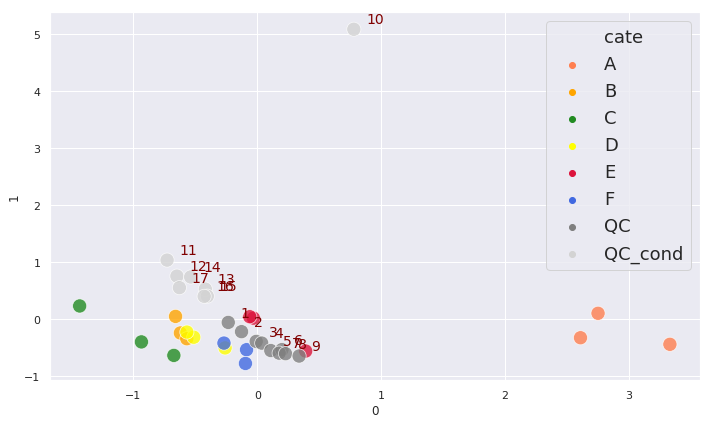

In [272]:
t = into_pos.iloc[:, 1:].dropna()

pca_df = draw_pca(t / (t.mean(0)/t.mean(0).max()))

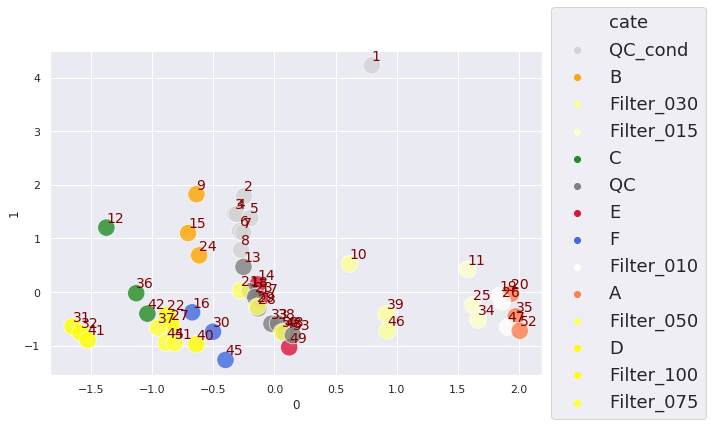

In [424]:
pca_df = draw_pca(into_pos.iloc[:, 1:].fillna(10), fi=True)

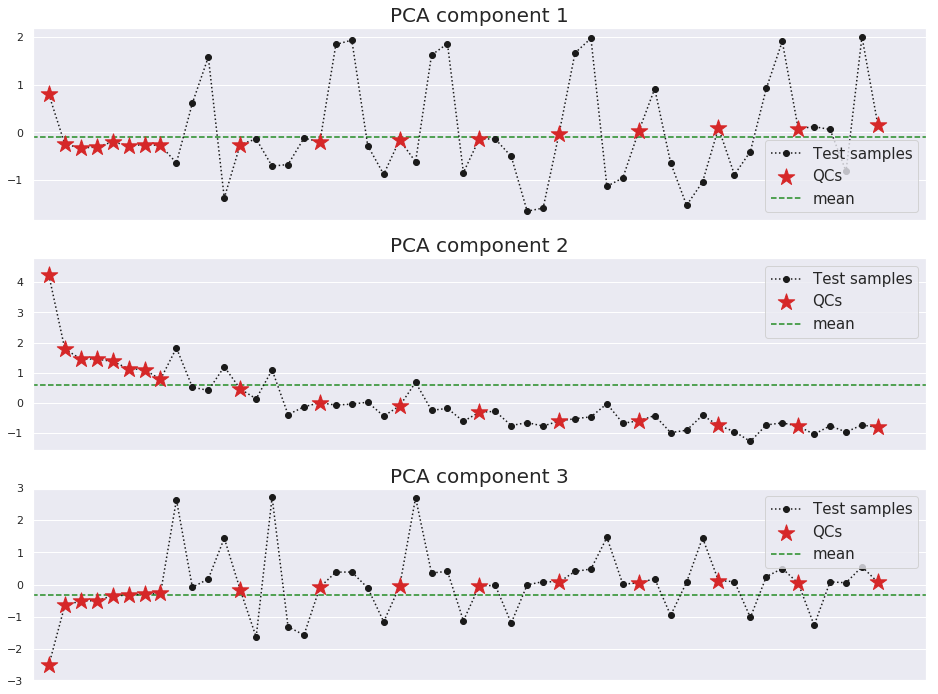

In [426]:
fig, [ax1, ax2, ax3] = plt.subplots(3,1,figsize=(16,12))
ax1.plot(pca_df[0], ':o', c='k', label='Test samples')
_ = pca_df[pca_df.index.str.contains('QC')]
ax1.scatter(_.index, _[0], marker='*', s=300, c='tab:red', zorder=10, label='QCs')
ax1.set_xticklabels([])
ax1.set_title('PCA component 1', fontsize=20)
ax1.hlines(_[0].mean(), -10, 100, linestyle='--', color='forestgreen', label='mean')
ax1.set_xlim(-1,55)
ax1.legend(fontsize=15)
ax1.set_xticks([])

ax2.plot(pca_df[1], ':o', c='k', label='Test samples')
ax2.scatter(_.index, _[1], marker='*', s=300, c='tab:red', zorder=10, label='QCs')
ax2.set_xticklabels([])
ax2.set_title('PCA component 2', fontsize=20)
ax2.hlines(_[1].mean(), -10, 100, linestyle='--', color='forestgreen', label='mean')
ax2.set_xlim(-1,55)
ax2.legend(fontsize=15)
ax2.set_xticks([])

ax3.plot(pca_df[2], ':o', c='k', label='Test samples')
ax3.scatter(_.index, _[2], marker='*', s=300, c='tab:red', zorder=10, label='QCs')
ax3.set_xticklabels([])
ax3.set_title('PCA component 3', fontsize=20)
ax3.hlines(_[2].mean(), -10, 100, linestyle='--', color='forestgreen', label='mean')
ax3.set_xlim(-1,55)
ax3.legend(fontsize=15)
ax3.set_xticks([]);

In [53]:
test = into_neg.iloc[:, 1:].dropna()
test = pd.DataFrame(test.sum(0))
test['cate'] = test.index
test['cate'] = test.apply(lambda x: classify(x['cate']), axis=1)

In [82]:
for index in index_neg_qc:
    print((into_neg.iloc[:, 25]/into_neg.iloc[:, index]).median())

0.9448525395422491
0.9603630012436181
0.9744729819629026
0.9796054028488996
1.0
0.995979111839243
1.0074458578837064
1.014332335495614
1.023315189743868


In [89]:
for index in index_pos_qc:
    if index<8:
        print('cond~~~', end='~')
    print((into_pos.iloc[:, 28]/into_pos.iloc[:, index]).median())

cond~~~~1.095602854565508
cond~~~~0.9111529838152466
cond~~~~0.892258883314839
cond~~~~0.8949613977001415
cond~~~~0.9096104090739305
cond~~~~0.9114696346423417
cond~~~~0.9161175475370074
0.9234554297997397
0.9441093616778461
0.974295538674951
0.991557810391413
1.0
1.0440884737438632
1.0470509989202306
1.0867890718269355
1.082854663906054
1.1003931159023455


In [231]:
index

53

In [236]:
into_pos = into_pos.dropna()

In [6]:
for index in into_pos.columns[1:]:
    print(f'{index}:{(into_pos.iloc[:, 28]/into_pos[index]).median()}')

QC_cond1:1.095602854565508
QC_cond2:0.9111529838152466
QC_cond3:0.892258883314839
QC_cond4:0.8949613977001415
QC_cond5:0.9096104090739305
QC_cond6:0.9114696346423417
QC_cond7:0.9161175475370074
QC_cond8:0.9234554297997397
B_1:0.9209871929695197
Filter_030_1:1.2701192703341717
Filter_015_1:2.1441730867609836
C_2:0.833494281623695
QC_1:0.9441093616778461
E_2:0.9958234325602611
B_2:0.9279262843206615
F_1:0.9266888287317518
E_1:0.9930361451409991
QC_2:0.974295538674951
Filter_010_2:2.6583370900020853
A_2:2.284735707182314
Filter_050_3:0.9497722679706355
D_3:0.9242792361481306
QC_3:0.991557810391413
B_3:0.9647485988246295
Filter_015_3:2.22989407674527
Filter_010_1:2.647696969981939
D_1:0.9253975358058882
QC_4:1.0
Filter_050_1:0.982378121930828
F_2:0.957516422036528
Filter_100_2:0.7009230301232838
Filter_100_1:0.7145564474597667
QC_5:1.0440884737438632
Filter_015_2:2.3188201367270995
A_3:2.334377445469295
C_1:0.8898117347014219
Filter_075_2:0.8087262105399002
QC_6:1.0470509989202306
Filter_0

In [102]:
import statsmodels.api as sm

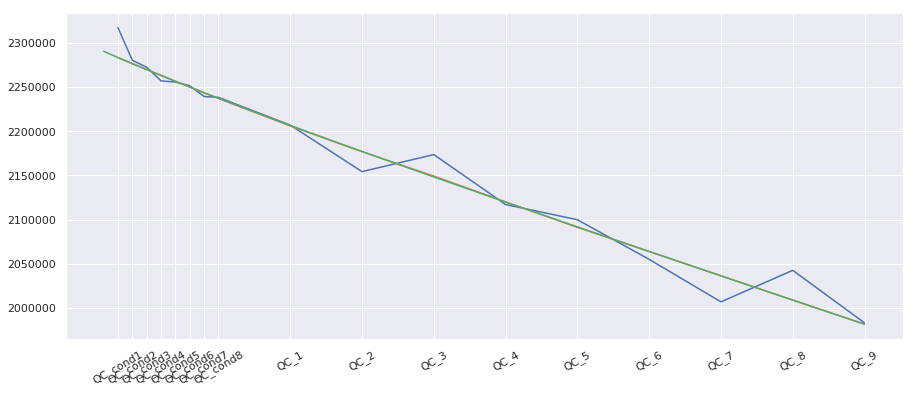

In [226]:
lowess = sm.nonparametric.lowess(into_pos.iloc[:, index_pos_qc].median(0), index_pos_qc)
plt.figure(figsize=(15,6))
plt.plot(index_pos_qc, into_pos.iloc[:, index_pos_qc].median(0))
plt.plot(lowess[:,0], lowess[:,1])
plt.plot(np.arange(0,54), np.poly1d(np.polyfit(lowess[:,0], lowess[:,1], 5))(np.arange(0, 54)))
plt.tick_params('x', rotation=30)
plt.xticks(index_pos_qc, into_pos.iloc[:, index_pos_qc].columns);

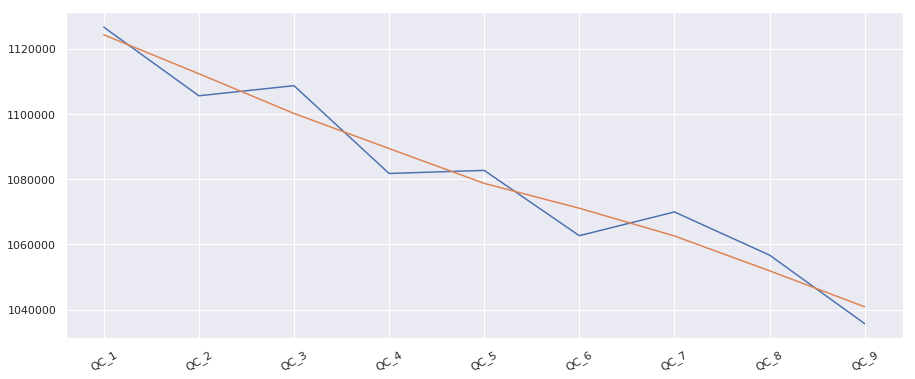

In [229]:
lowess = sm.nonparametric.lowess(into_neg.iloc[:, index_neg_qc].median(0), index_neg_qc)
plt.figure(figsize=(15,6))
plt.plot(index_neg_qc, into_neg.iloc[:, index_neg_qc].median(0))
plt.plot(lowess[:,0], lowess[:,1])
plt.tick_params('x', rotation=30)
plt.xticks(index_neg_qc, into_neg.iloc[:, index_neg_qc].columns);

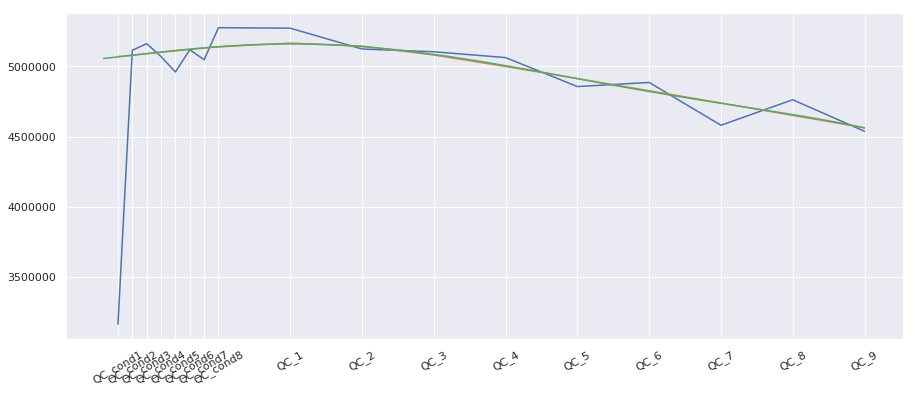

In [238]:
lowess = sm.nonparametric.lowess(into_pos.iloc[:, index_pos_qc].median(0), index_pos_qc)
plt.figure(figsize=(15,6))
plt.plot(index_pos_qc, into_pos.iloc[:, index_pos_qc].median(0))
plt.plot(lowess[:,0], lowess[:,1])
plt.plot(np.arange(0,54), np.poly1d(np.polyfit(lowess[:,0], lowess[:,1], 5))(np.arange(0, 54)))
plt.tick_params('x', rotation=30)
plt.xticks(index_pos_qc, into_pos.iloc[:, index_pos_qc].columns);

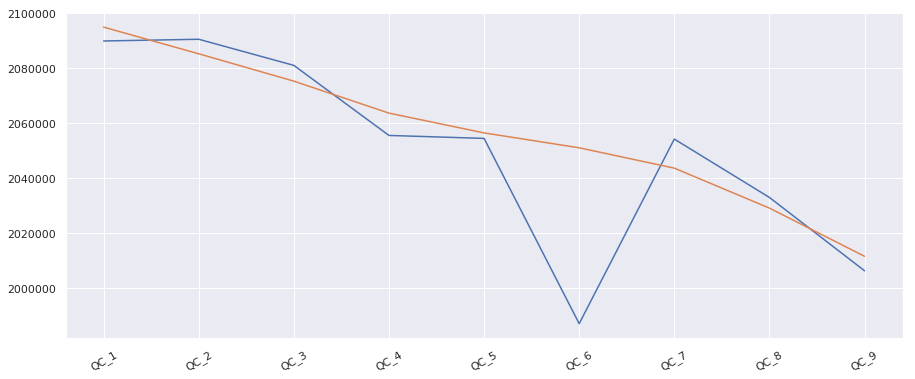

In [241]:
#when dropna, what happened
lowess = sm.nonparametric.lowess(into_neg.iloc[:, index_neg_qc].median(0), index_neg_qc)
plt.figure(figsize=(15,6))
plt.plot(index_neg_qc, into_neg.iloc[:, index_neg_qc].median(0))
plt.plot(lowess[:,0], lowess[:,1])
plt.tick_params('x', rotation=30)
plt.xticks(index_neg_qc, into_neg.iloc[:, index_neg_qc].columns);

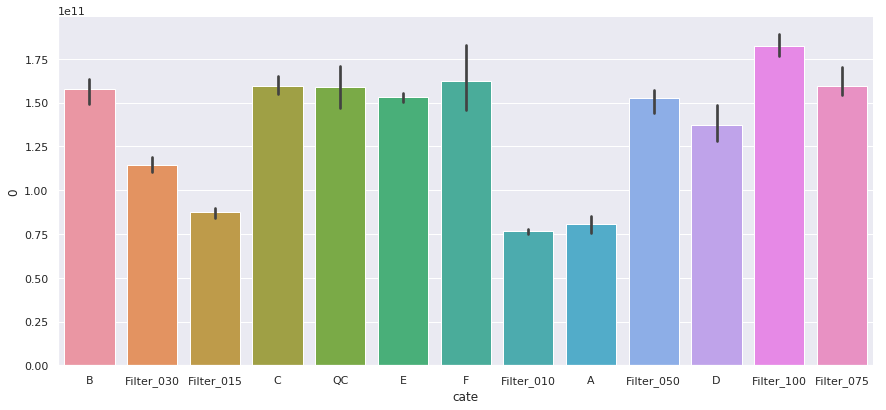

In [51]:
g = sns.catplot(x='cate', y=0, data=test, kind='bar')
fig = g.fig
fig.set_size_inches(15,6)

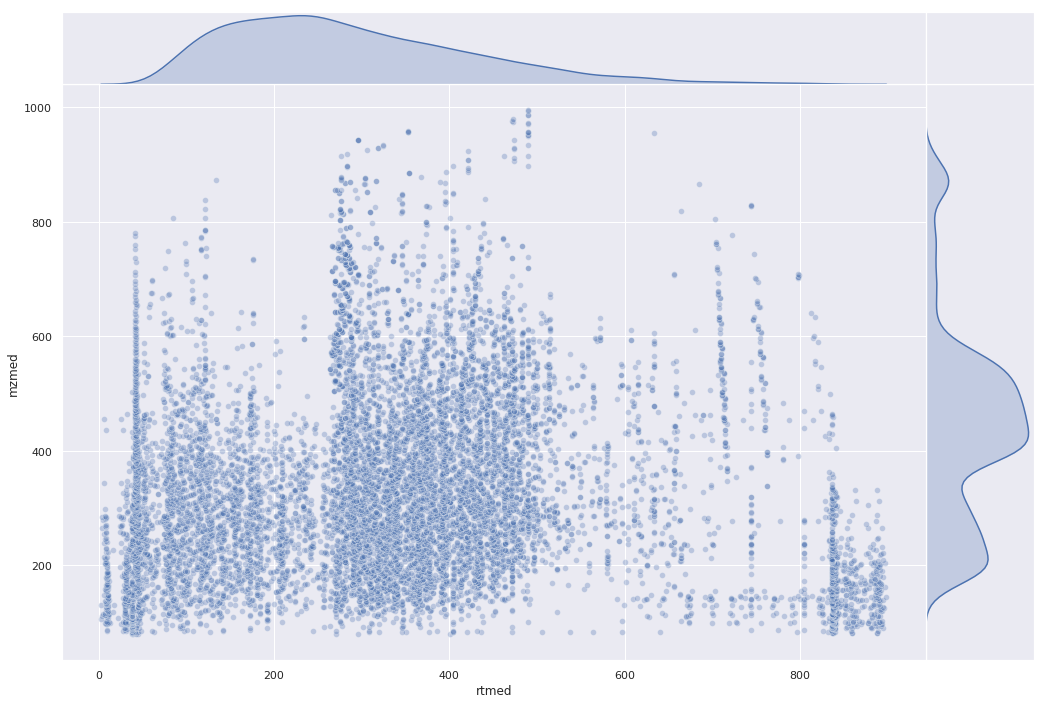

In [152]:
plt.figure(figsize=(15,10))
ax1 = plt.axes([0.9, 0.1, 0.1, 0.8]) # up
ax2 = plt.axes([0.1, 0.1, 0.8, 0.8]) # main
ax3 = plt.axes([0.1, 0.9, 0.8, 0.1]) # bottom
ax4 = plt.axes([0.9, 0.9, 0.1, 0.1])
ax1.set_xticks([])
ax1.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
sns.scatterplot('rtmed', 'mzmed', data=fd_pos, alpha=.3, ax=ax2, zorder=10)
sns.kdeplot(fd_pos['rtmed'], shade=True, ax=ax1, vertical=True, legend='')
sns.kdeplot(fd_pos['mzmed'], shade=True, ax=ax3, legend='')

In [366]:
save()

data saved
